In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Flatten,BatchNormalization,Conv2D,MaxPool2D
import tensorflow_datasets as tfds
from keras.layers.preprocessing.image_preprocessing import Rescaling,Resizing,RandomFlip,RandomRotation
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
# loading the data into tf dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:

class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
# data agumentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
horizontal_flip=True, fill_mode="nearest")

In [28]:
data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal_and_vertical"))
data_augmentation.add(RandomRotation(0.2))

In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## spliting the data into train, validation, test data for the model

# building the model

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model =Sequential()
model.add(Resizing(IMAGE_SIZE, IMAGE_SIZE))
model.add(Rescaling(1./255))
model.add(Conv2D(32, kernel_size = (3,3), activation='relu',input_shape=input_shape))
model.add(MaxPool2D(2))
model.add(Conv2D(64, kernel_size = (3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64,kernel_size=3,activation="relu"))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(n_classes,activation="softmax"))
model.build(input_shape=input_shape)

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
early_stop=EarlyStopping(monitor="val_accuracy",patience=3)
check=ModelCheckpoint("best_weights.h5",monitor="val_accuracy")

In [39]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[check]
)

Epoch 1/50
54/54 [==============================] - 27s 486ms/step - loss: 0.7127 - accuracy: 0.6910 - val_loss: 0.4517 - val_accuracy: 0.8385
Epoch 2/50
54/54 [==============================] - 32s 593ms/step - loss: 0.3963 - accuracy: 0.8391 - val_loss: 0.2640 - val_accuracy: 0.8854
Epoch 3/50
54/54 [==============================] - 35s 651ms/step - loss: 0.2050 - accuracy: 0.9190 - val_loss: 0.2312 - val_accuracy: 0.8958
Epoch 4/50
54/54 [==============================] - 36s 655ms/step - loss: 0.1652 - accuracy: 0.9421 - val_loss: 0.2284 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 35s 645ms/step - loss: 0.1812 - accuracy: 0.9311 - val_loss: 0.2332 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 35s 649ms/step - loss: 0.1334 - accuracy: 0.9520 - val_loss: 0.1256 - val_accuracy: 0.9583
Epoch 7/50
54/54 [==============================] - 36s 659ms/step - loss: 0.1100 - accuracy: 0.9589 - val_loss: 0.3239 - val_accuracy: 0.8698

In [40]:
model.load_weights("best_weights.h5")

In [41]:
model.evaluate(test_ds)

8/8 [==============================] - 7s 86ms/step - loss: 0.0907 - accuracy: 0.9648


[0.09074409306049347, 0.96484375]

#### the accuracy still good

No handles with labels found to put in legend.
No handles with labels found to put in legend.


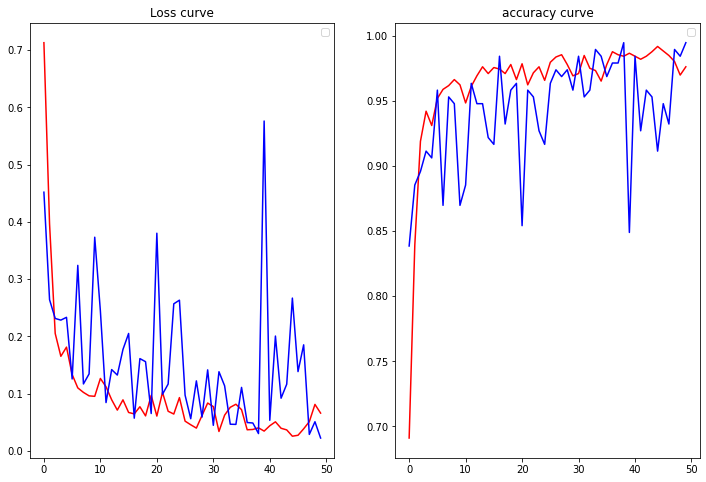

In [55]:
plt.figure(figsize=(12,8))
ax=plt.subplot(1,2,1)
ax.plot(history.history["loss"],"r",history.history["val_loss"],"b")
ax.set_title("Loss curve")
ax.set_label(["train"])
ax.legend()
ax2=plt.subplot(1,2,2)
ax2.plot(history.history["accuracy"],"r",history.history["val_accuracy"],"b")
ax2.set_title("accuracy curve")
plt.legend() 


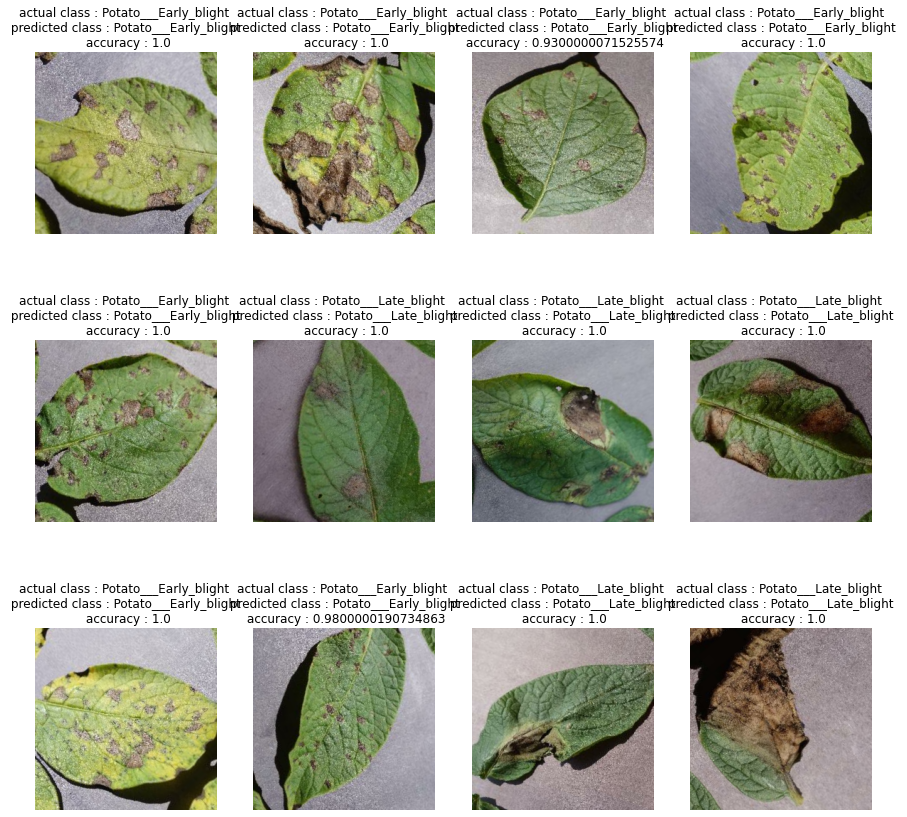

In [64]:
# showing some predictions
plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype('u8'))
        predictions=model.predict(images)
        predicted_class=class_names[np.argmax(predictions[i])]
        accuracy= round(np.max(predictions[i]),2)
        actual_class= class_names[labels[i]]
        plt.title(f"actual class : {actual_class} \n predicted class : {predicted_class} \n accuracy : {accuracy}")
        plt.axis('off')

### acrually the model is doing a great job

In [62]:
model.save("models/ version_1")

INFO:tensorflow:Assets written to: models/ version_1\assets
